In [27]:
import numpy as np
import joblib
import json
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from src.models.VAE import  VAE1D, compute_scores
import pandas as pd
import zipfile

from torch.utils.data import DataLoader, TensorDataset 
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load test set

In [ ]:
from src.utils import find_folder

data_dir = find_folder('.', 'data_processed')
npz_path = os.path.join(data_dir, "data_processed.npz")

data = np.load(npz_path)

X_test_signal_raw   = data["X_test_signal_raw"]
X_test_coeffs_raw   = data["X_test_coeffs_raw"]
y_test              = data["y_test"]

mean_x              = data["mean_x"]
std_x               = data["std_x"]
mean_c              = data["mean_c"]
std_c               = data["std_c"]

normal_class_id     = data["normal_class_id"]

In [ ]:
# Normalizo con las estadísticas de dev
X_test_signal  = (X_test_signal_raw  - mean_x) / (std_x  + 1e-8)
X_test_coeffs  = (X_test_coeffs_raw  - mean_c) / (std_c  + 1e-8)

In [18]:
test_norm_signal = X_test_signal[y_test == normal_class_id]
test_norm_coeffs = X_test_coeffs[y_test == normal_class_id] 
test_ano_signal  = X_test_signal[y_test != normal_class_id]
test_ano_coeffs  = X_test_coeffs[y_test != normal_class_id]

test_norm_signal_tensor = torch.tensor(test_norm_signal).permute(0, 2, 1)
test_ano_signal_tensor = torch.tensor(test_ano_signal).permute(0, 2, 1)

test_norm_coeffs_tensor = torch.tensor(test_norm_coeffs)
test_ano_coeffs_tensor = torch.tensor(test_ano_coeffs)

### Load Models

In [ ]:
in_dir = find_folder('.', 'saved_models_and_params')

# Cargar best_hps.json
with open(os.path.join(in_dir, "best_hps.json"), "r") as f:
    hps = json.load(f)

beta_value  = hps["beta"]
lr          = hps["lr"]
latent_dim  = int(hps["latent_dim"])
n_blocks    = int(hps["n_blocks"])
batch_size  = int(hps["batch_size"])
epochs      = int(hps["epochs"])


In [6]:
NUM_INPUT_CH = 1
NUM_COEFF_CH = 21

In [ ]:
# Cargar VAE
model = VAE1D(input_ch=NUM_INPUT_CH, coeff_ch=NUM_COEFF_CH, latent_dim=latent_dim, n_blocks=n_blocks)
vae_path = os.path.join(in_dir, "vae_state.pth")
model.load_state_dict(torch.load(vae_path, map_location=device))
model.to(device)
model.eval()

VAE1D(
  (signal_encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(19,), stride=(2,), padding=(9,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ResBlock1D(
      (block): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (3): ResBlock1D(
      (block): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      )
    )
    (4): ResBlock1D(
      (block): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
      )
    )
  )
  (flatten): Flatten(start_dim=1

In [ ]:
# Cargar XGB y umbral
clf       = joblib.load(os.path.join(in_dir, "xgb_clf.joblib"))
best_thresh = json.load(open(os.path.join(in_dir, "threshold.json"), "r"))["best_thresh"]

## `Testing`

In [ ]:
# Balanceamos test set para que las métricas sean coherentes

N_norm = len(test_norm_signal_tensor)
N_ano  = len(test_ano_signal_tensor)
N_test = min(N_norm, N_ano)

norm_signals_test = test_norm_signal_tensor[:N_test]
ano_signals_test  = test_ano_signal_tensor[:N_test]
norm_coeffs_test  = test_norm_coeffs_tensor[:N_test]
ano_coeffs_test   = test_ano_coeffs_tensor[:N_test]

X_test_final_signal = torch.cat([norm_signals_test, ano_signals_test], dim=0)
X_test_final_coeffs = torch.cat([norm_coeffs_test, ano_coeffs_test], dim=0)

y_test_final = torch.tensor(
    np.concatenate([np.zeros(N_test), np.ones(N_test)]),
    dtype=torch.long
)

test_loader_final = DataLoader(TensorDataset(X_test_final_signal, X_test_final_coeffs, y_test_final), batch_size=batch_size)

In [16]:
print("Extracting features from the unseen test set...")
errs_test, zs_test = compute_scores(model, test_loader_final, device, beta=beta_value)
errs_test = np.nan_to_num(errs_test, nan=0.0, posinf=1e6, neginf=-1e6)
zs_test = np.nan_to_num(zs_test, nan=0.0, posinf=1e6, neginf=-1e6)
X_test_clf = np.hstack([errs_test.reshape(-1, 1), zs_test])
y_test_clf = y_test_final.numpy()

Extracting features from the unseen test set...


In [ ]:
print("Evaluating classifier on the unseen test set...")
probs = clf.predict_proba(X_test_clf)[:, 1]
y_pred = (probs >= best_thresh).astype(int)

metrics = {
    'roc_auc': roc_auc_score(y_test_clf, probs),
    'precision': precision_score(y_test_clf, y_pred), 
    'recall': recall_score(y_test_clf, y_pred),
    'f1': f1_score(y_test_clf, y_pred),
    'accuracy': accuracy_score(y_test_clf, y_pred)
}

Evaluating classifier on the unseen test set...


## `Results`

In [14]:
from src.utils import display_metrics_as_md
display_metrics_as_md(metrics)

<h2 style='margin-bottom:0.3em'>Final Metrics on Unseen Test Set</h2>
<p style='font-size:16px; margin:0.2em 0'><strong>Roc Auc:</strong> 0.9151</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Precision:</strong> 0.9207</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Recall:</strong> 0.7084</p>
<p style='font-size:16px; margin:0.2em 0'><strong>F1:</strong> 0.8007</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Accuracy:</strong> 0.8237</p>



Matriz de confusión:
           Pred Neg  Pred Pos
Real Neg     50759      3297
Real Pos     15763     38293


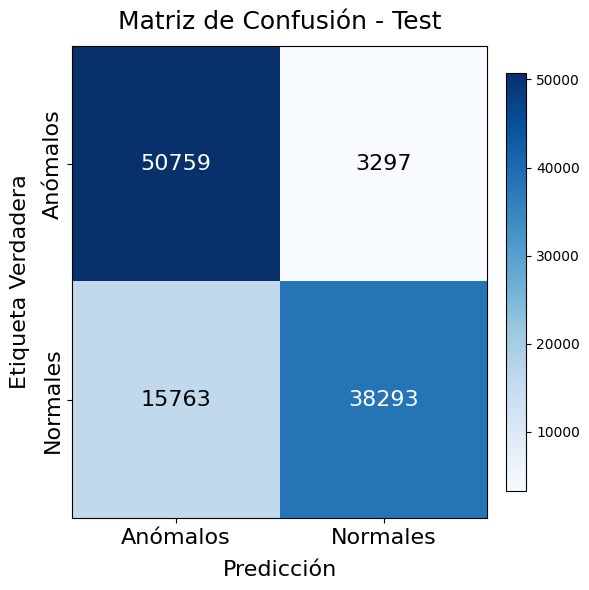

In [24]:
cm_val = confusion_matrix(y_test_clf, y_pred)  

cm_val_df = pd.DataFrame(
    cm_val,
    index=["Real Neg","Real Pos"],
    columns=["Pred Neg","Pred Pos"]
)
print("\nMatriz de confusión:\n", cm_val_df)

from src.plot_metrics import plot_confusion_matrix

plot_confusion_matrix(cm_val, class_names=["Anómalos", "Normales"], title="Matriz de Confusión - Test")

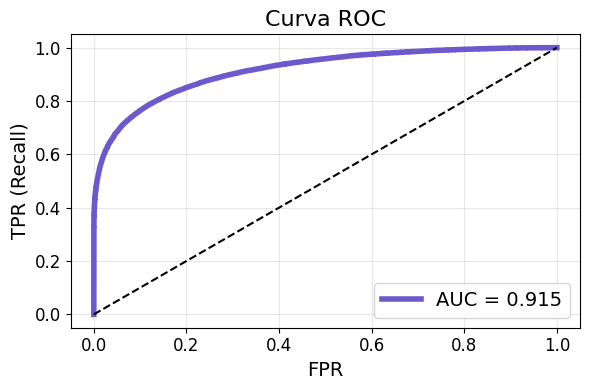

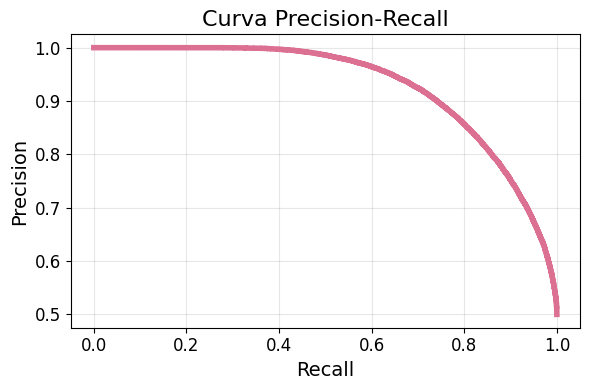

In [26]:
from src.plot_metrics import plot_roc_pr

plot_roc_pr(y_test_clf, probs, lw=4, font_size=14, roc_color='slateblue', pr_color='palevioletred')

### Save Predictions

In [28]:
apellido1 = "Tissera"
apellido2 = "Couriel" 
model_name = "VAE1D"    

df_preds = pd.DataFrame({
    "y_true": y_test_clf,
    "y_pred": y_pred,
    "prob_positive": probs
})

csv_filename = f"{apellido1}_{apellido2}_{model_name}_predictions.csv"
df_preds.to_csv(csv_filename, index=False)
print(f"Archivo CSV guardado: {csv_filename}")

Archivo CSV guardado: Tissera_Couriel_VAE1D_predictions.csv


In [29]:
# A zip
zip_filename = f"{apellido1}_{apellido2}_Predictions_PF.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_filename) 
print(f"Archivo ZIP generado: {zip_filename}")

Archivo ZIP generado: Tissera_Couriel_Predictions_PF.zip
